# MẪU TUẦN TỰ THỜI GIAN (Sequential Pattern) với Time Series
## Phát hiện xu hướng tai nạn theo thời gian

**Mục tiêu:**
- Phân tích xu hướng tai nạn qua các năm (2018-2023)
- Phát hiện mùa vụ và chu kỳ tai nạn
- Xác định các mẫu theo giờ, ngày, tháng
- Dự đoán các giai đoạn có nguy cơ cao

**Kỹ thuật:** Time Series Analysis với STL Decomposition

## 1. Import thư viện cần thiết

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import os

warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Tạo thư mục lưu hình ảnh
os.makedirs('figures/sequential', exist_ok=True)

## 2. Đọc và chuẩn bị dữ liệu

In [2]:
# Đọc dữ liệu đã tiền xử lý (sử dụng tên cột UPPERCASE từ preprocessed dataset)
df = pd.read_csv('../ssis_project/preprocess/US_Accidents_March23-preprocessed.csv',
                 usecols=['SEVERITY', 'STATE', 'TEMPERATURE', 'VISIBILITY',
                         'WEATHER_CONDITION', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'DATE'],
                 dtype={
                     'SEVERITY': 'int8',
                     'STATE': 'category',
                     'TEMPERATURE': 'float32',
                     'VISIBILITY': 'float32',
                     'WEATHER_CONDITION': 'category',
                     'YEAR': 'int16',
                     'MONTH': 'int8',
                     'DAY': 'int8',
                     'HOUR': 'int8',
                     'DATE': 'str'
                 },
                 low_memory=False)

df['DATE'] = pd.to_datetime(df['DATE'])
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek  # 0=Monday, 6=Sunday
df['WEEK_OF_YEAR'] = df['DATE'].dt.isocalendar().week
df = df[(df['YEAR'] >= 2018) & (df['YEAR'] <= 2023)]
print(f"Rows: {len(df):,}; Range: {df['DATE'].min().date()} → {df['DATE'].max().date()}")

Rows: 5,539,531; Range: 2018-01-01 → 2023-03-31


## 3. Tổng hợp dữ liệu theo ngày

In [3]:
# Tổng hợp số lượng tai nạn theo ngày
daily_accidents = df.groupby('DATE').size().reset_index(name='ACCIDENT_COUNT')
daily_accidents['DATE'] = pd.to_datetime(daily_accidents['DATE'])
daily_accidents = daily_accidents.set_index('DATE').sort_index()

date_range = pd.date_range(start=daily_accidents.index.min(),
                           end=daily_accidents.index.max(),
                           freq='D')
daily_accidents = daily_accidents.reindex(date_range, fill_value=0)
daily_accidents.index.name = 'DATE'
print(f"Daily series: {len(daily_accidents):,} days; mean accidents/day: {daily_accidents['ACCIDENT_COUNT'].mean():.1f}")

Daily series: 1,916 days; mean accidents/day: 2891.2


## 6. Heatmap 1: Mẫu theo GIỜ × NGÀY TRONG TUẦN

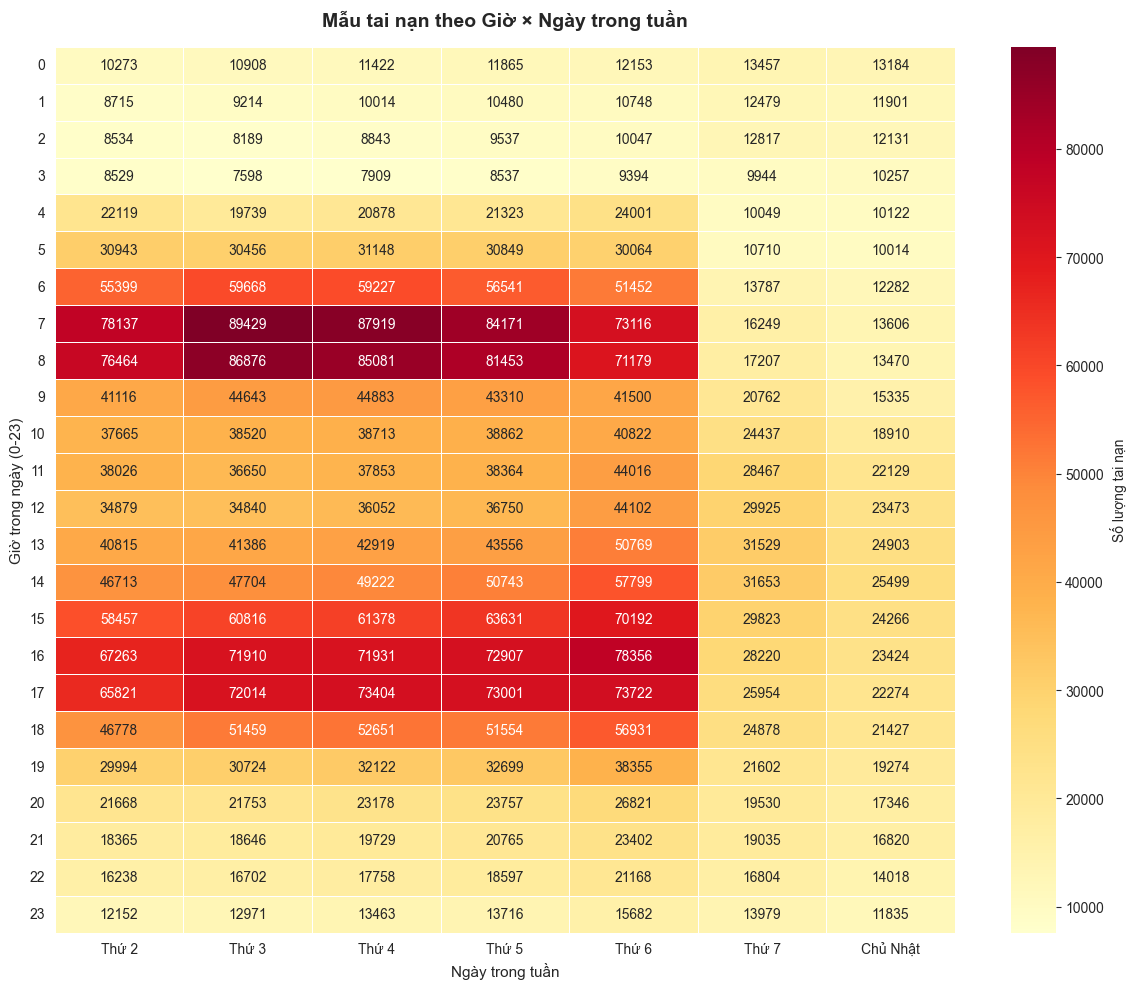

Saved: figures/sequential/03_heatmap_hour_dayofweek.png


In [4]:
# Tạo bảng pivot: Giờ × Ngày trong tuần
hour_dayofweek = df.groupby(['HOUR', 'DAY_OF_WEEK']).size().reset_index(name='COUNT')
hour_dayofweek_pivot = hour_dayofweek.pivot(index='HOUR', columns='DAY_OF_WEEK', values='COUNT')

day_names = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ Nhật']
hour_dayofweek_pivot.columns = day_names

plt.figure(figsize=(12, 10))
sns.heatmap(hour_dayofweek_pivot,
            cmap='YlOrRd',
            annot=True,
            fmt='.0f',
            linewidths=0.5,
            cbar_kws={'label': 'Số lượng tai nạn'})
plt.title('Mẫu tai nạn theo Giờ × Ngày trong tuần', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Ngày trong tuần', fontsize=11)
plt.ylabel('Giờ trong ngày (0-23)', fontsize=11)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('figures/sequential/03_heatmap_hour_dayofweek.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: figures/sequential/03_heatmap_hour_dayofweek.png")

## 7. Heatmap 2: Mẫu theo THÁNG × NĂM

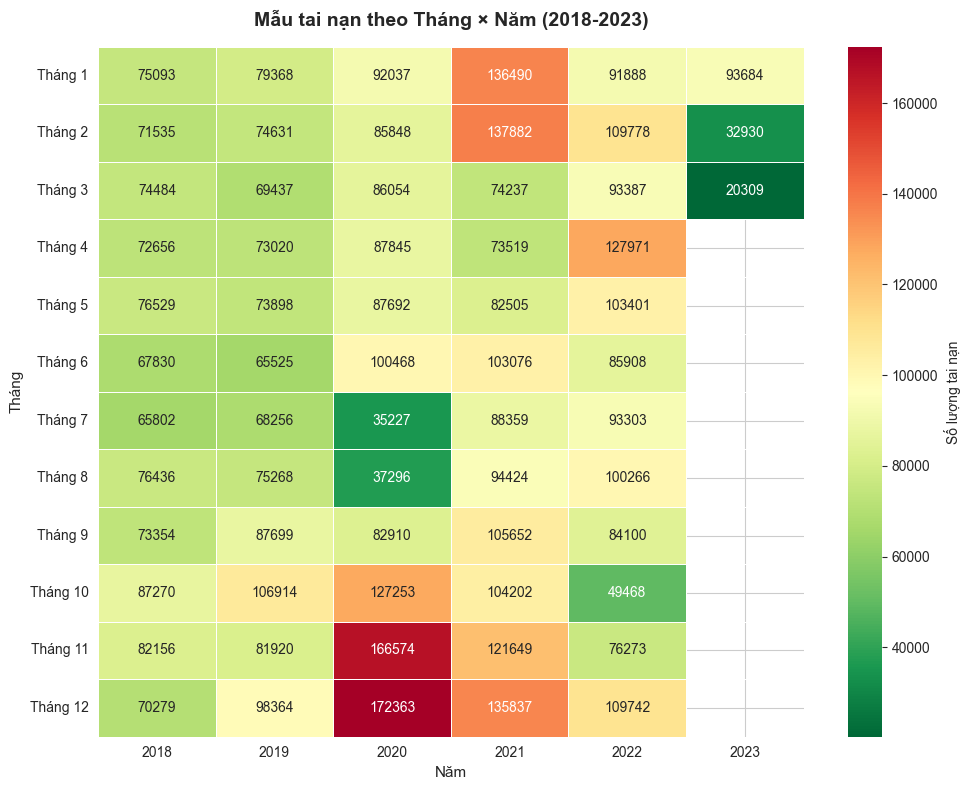

Saved: figures/sequential/04_heatmap_month_year.png


In [5]:
# Tạo bảng pivot: Tháng × Năm
month_year = df.groupby(['MONTH', 'YEAR']).size().reset_index(name='COUNT')
month_year_pivot = month_year.pivot(index='MONTH', columns='YEAR', values='COUNT')

month_names = ['Tháng 1', 'Tháng 2', 'Tháng 3', 'Tháng 4', 'Tháng 5', 'Tháng 6',
               'Tháng 7', 'Tháng 8', 'Tháng 9', 'Tháng 10', 'Tháng 11', 'Tháng 12']
month_year_pivot.index = month_names

plt.figure(figsize=(10, 8))
sns.heatmap(month_year_pivot,
            cmap='RdYlGn_r',
            annot=True,
            fmt='.0f',
            linewidths=0.5,
            cbar_kws={'label': 'Số lượng tai nạn'})
plt.title('Mẫu tai nạn theo Tháng × Năm (2018-2023)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Năm', fontsize=11)
plt.ylabel('Tháng', fontsize=11)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('figures/sequential/04_heatmap_month_year.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: figures/sequential/04_heatmap_month_year.png")

## 10. Phân tích bổ sung: Mẫu theo mùa và tuần trong năm

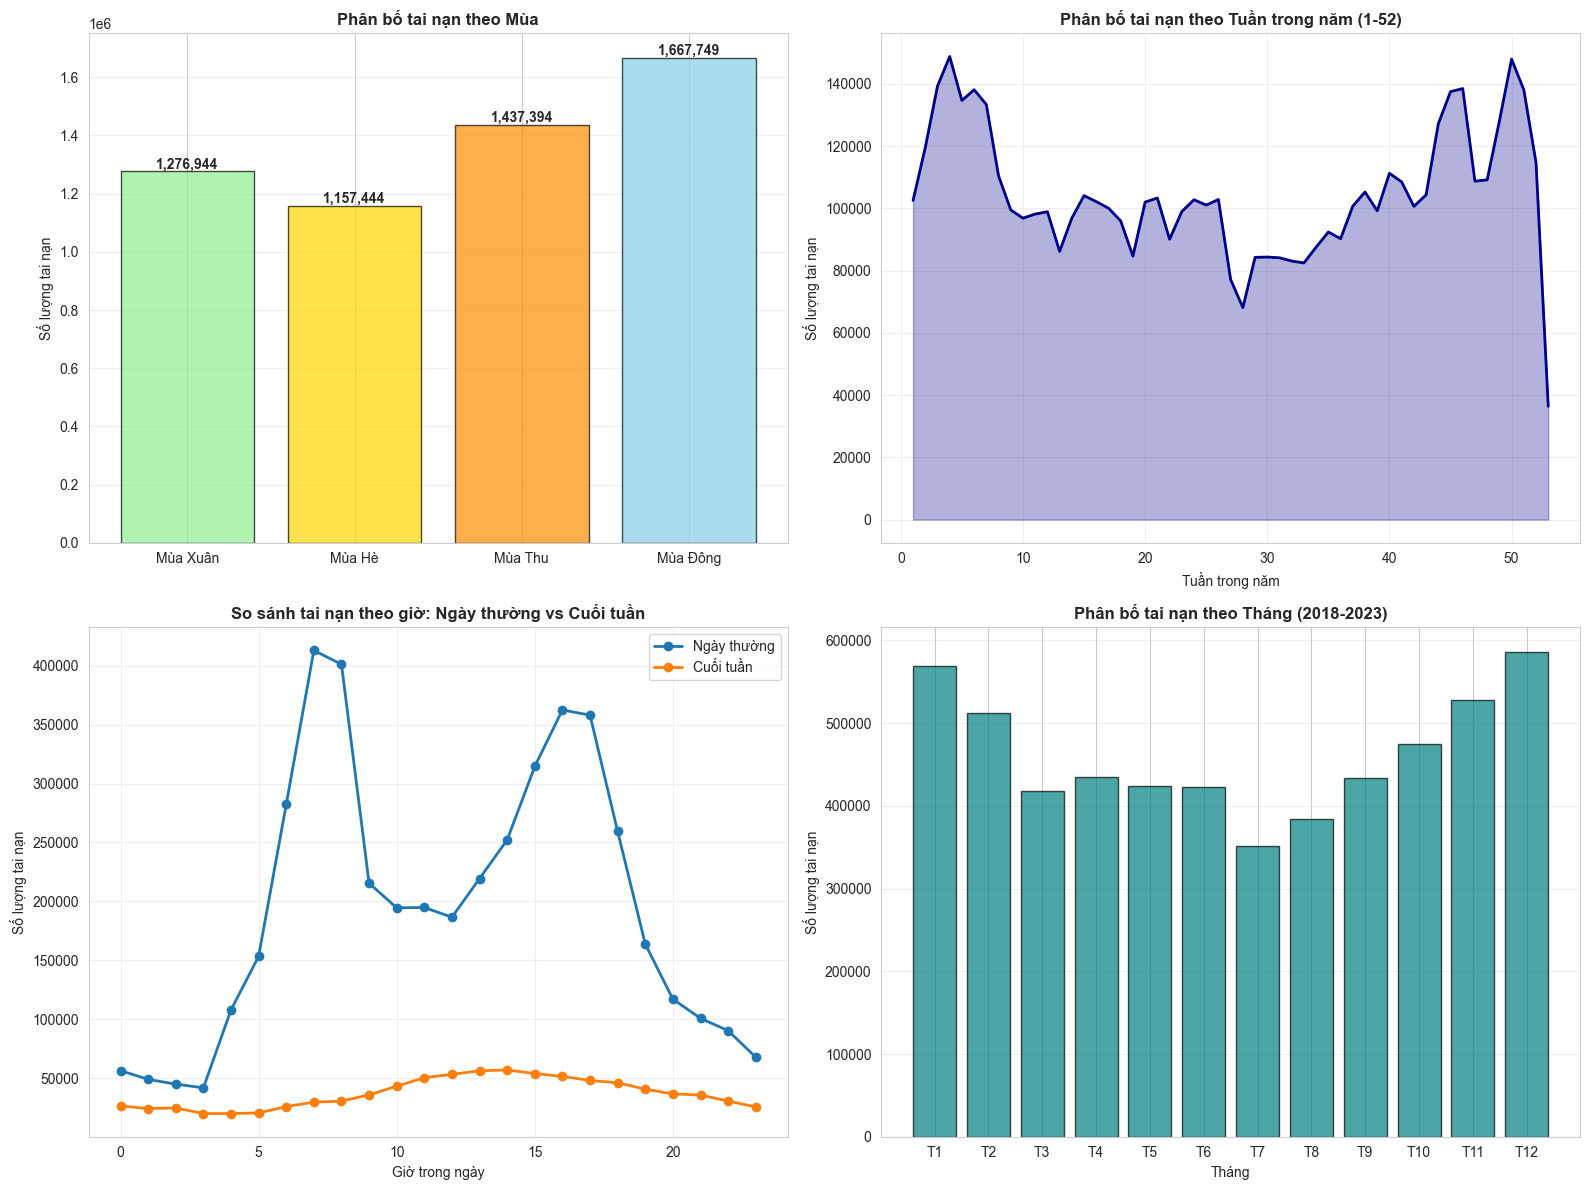

✓ Đã lưu: figures/sequential/07_seasonal_weekly_patterns.png


In [6]:
# Định nghĩa mùa
def get_season(month):
    if month in [12, 1, 2]:
        return 'Mùa Đông'
    elif month in [3, 4, 5]:
        return 'Mùa Xuân'
    elif month in [6, 7, 8]:
        return 'Mùa Hè'
    else:
        return 'Mùa Thu'

df['SEASON'] = df['MONTH'].apply(get_season)

# Tạo biểu đồ phân tích theo mùa và tuần
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Phân bố theo mùa
season_counts = df['SEASON'].value_counts()[['Mùa Xuân', 'Mùa Hè', 'Mùa Thu', 'Mùa Đông']]
colors = ['#90EE90', '#FFD700', '#FF8C00', '#87CEEB']
axes[0, 0].bar(season_counts.index, season_counts.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân bố tai nạn theo Mùa', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Số lượng tai nạn', fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(season_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Phân bố theo tuần trong năm
weekly_counts = df['WEEK_OF_YEAR'].value_counts().sort_index()
axes[0, 1].plot(weekly_counts.index, weekly_counts.values, linewidth=2, color='darkblue')
axes[0, 1].set_title('Phân bố tai nạn theo Tuần trong năm (1-52)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Tuần trong năm', fontsize=10)
axes[0, 1].set_ylabel('Số lượng tai nạn', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].fill_between(weekly_counts.index, weekly_counts.values, alpha=0.3, color='darkblue')

# 3. So sánh ngày thường vs cuối tuần
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([5, 6])  # Saturday=5, Sunday=6
weekend_comp = df.groupby(['IS_WEEKEND', 'HOUR']).size().reset_index(name='COUNT')
for is_weekend in [False, True]:
    data = weekend_comp[weekend_comp['IS_WEEKEND'] == is_weekend]
    label = 'Cuối tuần' if is_weekend else 'Ngày thường'
    axes[1, 0].plot(data['HOUR'], data['COUNT'], marker='o', linewidth=2, label=label)
axes[1, 0].set_title('So sánh tai nạn theo giờ: Ngày thường vs Cuối tuần', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Giờ trong ngày', fontsize=10)
axes[1, 0].set_ylabel('Số lượng tai nạn', fontsize=10)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Phân bố theo tháng (tổng hợp tất cả các năm)
monthly_counts = df['MONTH'].value_counts().sort_index()
month_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12']
axes[1, 1].bar(range(1, 13), monthly_counts.values, color='teal', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Phân bố tai nạn theo Tháng (2018-2023)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tháng', fontsize=10)
axes[1, 1].set_ylabel('Số lượng tai nạn', fontsize=10)
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(month_labels)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/sequential/07_seasonal_weekly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: figures/sequential/07_seasonal_weekly_patterns.png")

## 11. Tóm tắt các phát hiện chính (Key Insights)

In [7]:
# Tóm tắt nhanh các phát hiện chính
yearly_trend = df.groupby('YEAR').size()
trend_change = ((yearly_trend.iloc[-1] - yearly_trend.iloc[0]) / yearly_trend.iloc[0]) * 100
season_stats = df['SEASON'].value_counts()
hourly_stats = df['HOUR'].value_counts()
weekday_count = df[~df['DAY_OF_WEEK'].isin([5, 6])].shape[0]
weekend_count = df[df['DAY_OF_WEEK'].isin([5, 6])].shape[0]

print(f"Trend 2018→2023: {trend_change:+.1f}%")
print(f"Peak season: {season_stats.idxmax()} ({season_stats.max():,})")
print(f"Busiest hour: {hourly_stats.idxmax():02d}h ({hourly_stats.max():,})")
print(f"Weekday vs weekend: {weekday_count:,} vs {weekend_count:,}")

Trend 2018→2023: -83.6%
Peak season: Mùa Đông (1,667,749)
Busiest hour: 07h (442,627)
Weekday vs weekend: 4,648,334 vs 891,197


## 12. Kết luận
Tóm tắt chi tiết và khuyến nghị được chuyển sang README để giảm nội dung tĩnh trong notebook.